In [ ]:
#Installing Dependencies
!pip install tensorflow-io[tensorflow]

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
#Ensuring Files Exist
CAPUCHIN_FILE = os.path.join('drive', 'MyDrive', ' CCD_Data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('drive', 'MyDrive', ' CCD_Data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

print("CAPUCHIN_FILE exists:", os.path.exists(CAPUCHIN_FILE))
print("NOT_CAPUCHIN_FILE exists:", os.path.exists(NOT_CAPUCHIN_FILE))

CAPUCHIN_FILE exists: True
NOT_CAPUCHIN_FILE exists: True


In [3]:
#Loading And Converting Sampling Rate Of Audio To 16KHz
def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [4]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

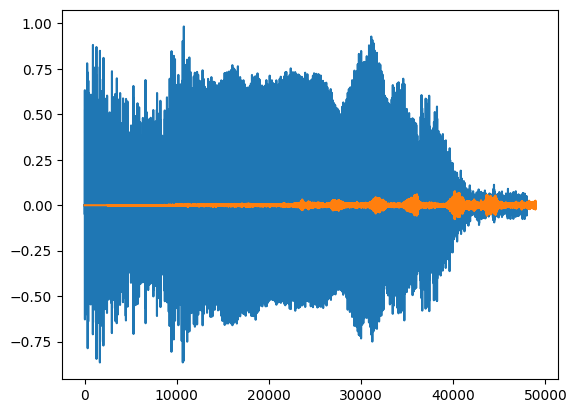

In [5]:
#Visualizing The Difference Between Presence And Abscence Of Call
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [6]:
#Loading Data From Positive And Negative Examples
POS = os.path.join('drive', 'MyDrive', ' CCD_Data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('drive', 'MyDrive', ' CCD_Data', 'Parsed_Not_Capuchinbird_Clips')

pos = tf.data.Dataset.list_files(POS + '/*.wav')
neg = tf.data.Dataset.list_files(NEG + '/*.wav')

#Balacing The Dataset
neg = neg.shuffle(700).take(222)

In [ ]:
#444 samples
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))

#Assign Class Weights If Imbalanced
'''
from sklearn.utils.class_weight import compute_class_weight

# Count samples
num_positives = len(pos)
num_negatives = len(neg)

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced",
                                    classes=np.array([0, 1]),
                                    y=np.array([0] * num_negatives + [1] * num_positives))

# Convert to dictionary
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
class_weights_dict[1] *= 2

print("Class Weights:", class_weights_dict)
'''

In [8]:
data = positives.concatenate(negatives)

In [ ]:
#Calculating Average Clip Length
lengths = []
for file in os.listdir(POS):
    tensor_wave = load_wav_16k_mono(os.path.join('drive', 'MyDrive', ' CCD_Data', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

In [21]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54126>

In [22]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [23]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [9]:
#Preprocessing Wav Into Spectrogram
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    spectrogram = tf.ensure_shape(spectrogram, [1491, 257, 1])

    return spectrogram, label

In [10]:
#Visualizing A Random Sample
filepath, label = positives.shuffle(buffer_size=400).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)

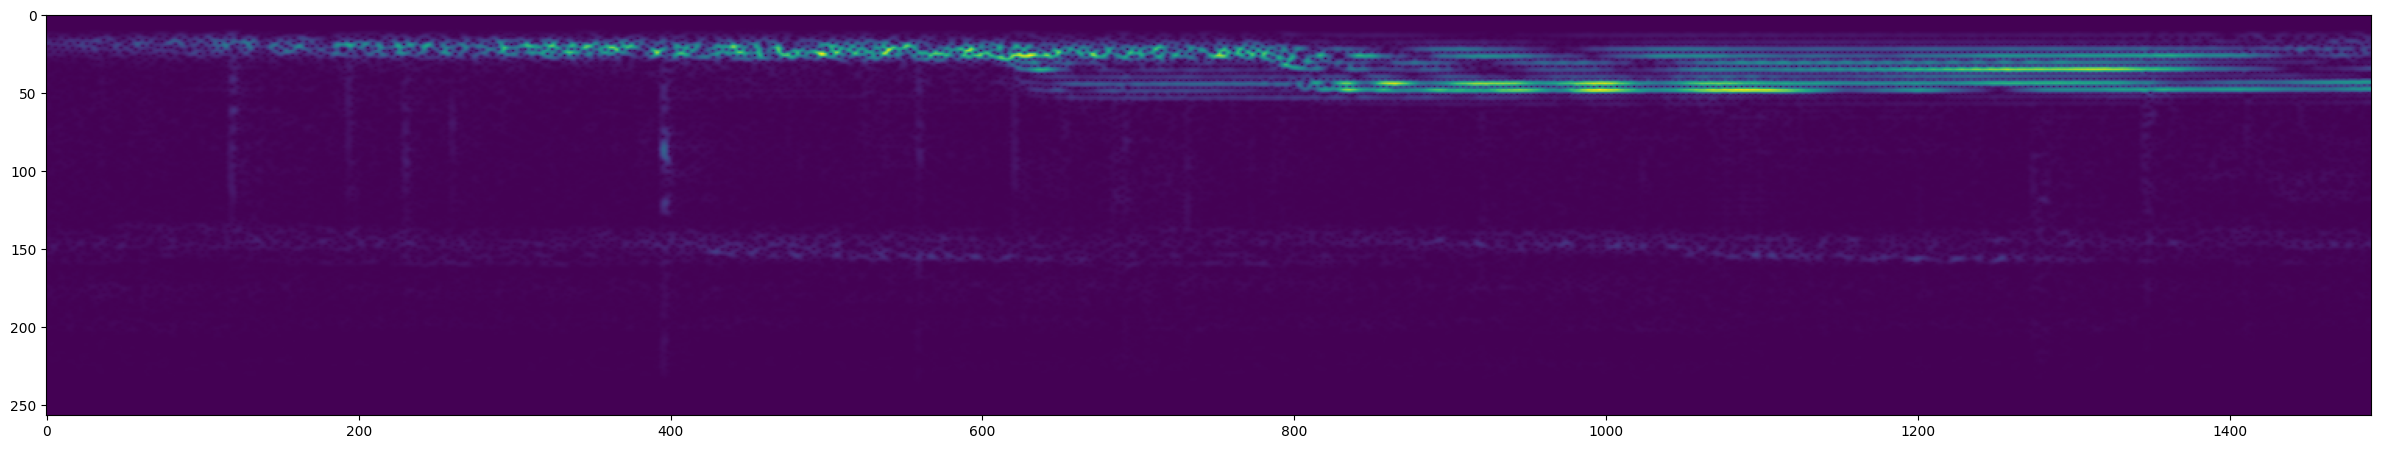

In [11]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [12]:
#Applying Preprocessing To Each Sample
data = data.map(preprocess)

# Apply Shuffle
data = data.shuffle(450).cache()

# Splitting Before Batching
train_size = 310
train_data = data.take(train_size)
test_data = data.skip(train_size).take(134)

#Batching And Prefetching
train = train_data.batch(16).prefetch(8)
test = test_data.batch(16).prefetch(8)

In [83]:
#Loading Sample
samples, labels = train.as_numpy_iterator().next()
samples.shape

(16, 1491, 257, 1)

In [13]:
#Building CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Input, GlobalMaxPooling2D, MaxPooling2D, Dropout, BatchNormalization, Flatten
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K

In [16]:
K.clear_session()

model = Sequential()

model.add(Input(shape=(1491, 257, 1)))

model.add(Conv2D(8, (3,3), activation='relu'))
model.add(MaxPooling2D((3,3)))
model.add(Dropout(0.3))

model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D((3,3)))
model.add(Dropout(0.3))

model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D((3,3)))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [17]:
#Configuring Callbacks, Loss Metrics and Compiling
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

def dice_loss(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

#Loss Metric For Imbalanced Dataset
'''
def tversky_loss(alpha=0.8, beta=0.2):
    def loss(y_true, y_pred):
        smooth = 1e-6
        tp = tf.reduce_sum(y_true * y_pred)
        fn = tf.reduce_sum(y_true * (1 - y_pred))
        fp = tf.reduce_sum((1 - y_true) * y_pred)
        return 1 - (tp + smooth) / (tp + alpha * fn + beta * fp + smooth)
    return loss
'''

model.compile(optimizer='adam', loss=dice_loss, metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 1489, 255, 8)        │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 496, 85, 8)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 496, 85, 8)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 494, 83, 16)         │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 164, 27, 16)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 164, 27, 16)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 162, 25, 16)         │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 54, 8, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 54, 8, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6912)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         884,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 888,561 (3.39 MB)

 Trainable params: 888,561 (3.39 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
tf.config.run_functions_eagerly(True)

In [19]:
hist = model.fit(train, epochs=10, validation_data=test, callbacks=[early_stopping])
model.save("model.keras")

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 235s 7s/step - loss: 0.2355 - precision: 0.6348 - recall: 0.9507 - val_loss: 0.0953 - val_precision: 0.8608 - val_recall: 1.0000
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step - loss: 0.1088 - precision: 0.8312 - recall: 0.9962 - val_loss: 0.0863 - val_precision: 0.8590 - val_recall: 0.9853
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step - loss: 0.0879 - precision: 0.8522 - recall: 0.9871 - val_loss: 0.0862 - val_precision: 0.8553 - val_recall: 0.9559
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - loss: 0.0885 - precision: 0.8444 - recall: 0.9846 - val_loss: 0.0868 - val_precision: 0.8590 - val_recall: 0.9853
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - loss: 0.0939 - precision: 0.8226 - recall: 0.9994 - val_loss: 0.0913 - val_precision: 0.8553 - val_recall: 0.9559
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - loss: 0.0853 - precision: 0.8367 - recall: 0.9971 - val_loss: 0.0811 - val_precision: 0.8590 - val_recall: 0.9853
Epo

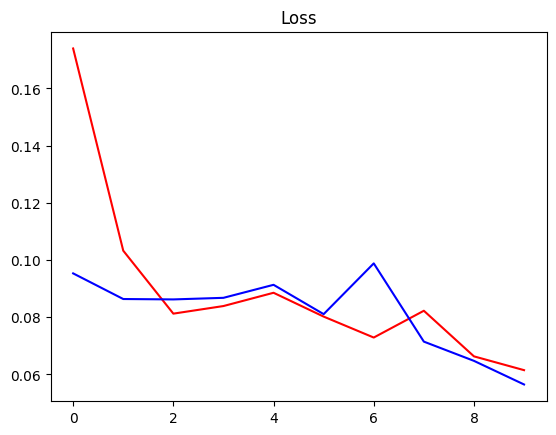

In [20]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

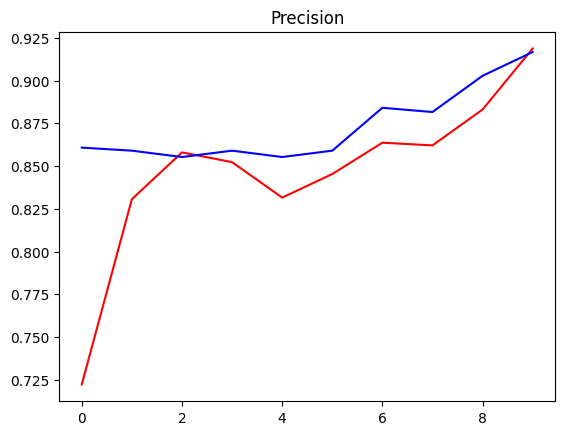

In [21]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

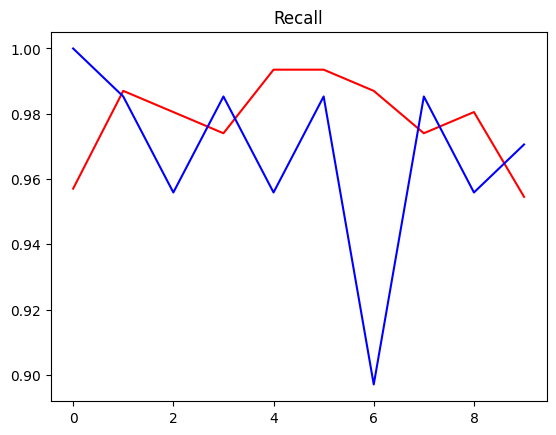

In [22]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [25]:
from tensorflow import keras
model = keras.models.load_model('model.keras', custom_objects={'dice_loss': dice_loss})
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 1489, 255, 8)        │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 496, 85, 8)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 496, 85, 8)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 494, 83, 16)         │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 164, 27, 16)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 164, 27, 16)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 162, 25, 16)         │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 54, 8, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 54, 8, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6912)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         884,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,665,685 (10.17 MB)

 Trainable params: 888,561 (3.39 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,777,124 (6.78 MB)

In [36]:
#Predict A Batch
X_test, y_test = test.as_numpy_iterator().next()
yhat = model.predict(X_test)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [37]:
print(yhat)
print(y_test)

[1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0]
[1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]


In [57]:
#Loading Audio Files
def load_mp3_16k_mono(filename):
    res = tfio.audio.AudioIOTensor(filename)
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
#Load A Sample
mp3 = os.path.join('drive', 'MyDrive', ' CCD_Data', 'Forest Recordings', 'recording_00.mp3')
wav = load_mp3_16k_mono(mp3)
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [59]:
len(audio_slices)

60

In [48]:
#Preprocessing Function For Audio Files
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    spectrogram = tf.ensure_shape(spectrogram, [1491, 257, 1])

    return spectrogram

In [ ]:
#Convert First Example To Slices For Prediction
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [64]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [67]:
#Predicts: 6
#True: 5
#Same Call Getting Counted Twice Because Of 3 Second Slots
tf.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=6>

In [68]:
#Removes Consecutive Duplicates
from itertools import groupby
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()
print(calls) #Predicts Correctly For First Example

5


In [69]:
#Predictions For Every File Appended To A List
results = {}
for file in os.listdir(os.path.join('drive', 'MyDrive', ' CCD_Data', 'Forest Recordings')):
    FILEPATH = os.path.join('drive', 'MyDrive', ' CCD_Data', 'Forest Recordings', file)

    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)

    yhat = model.predict(audio_slices)

    results[file] = yhat

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


In [77]:
results

{'recording_00.mp3': array([[2.97480053e-03],
        [2.65594870e-02],
        [8.74011964e-03],
        [9.56826091e-01],
        [1.00000000e+00],
        [2.73445086e-03],
        [7.77232368e-03],
        [3.07926536e-03],
        [1.38502999e-03],
        [7.53250113e-03],
        [5.18486323e-03],
        [5.52784884e-03],
        [6.33331109e-03],
        [9.93461251e-01],
        [1.00000000e+00],
        [4.69715660e-03],
        [8.72329653e-10],
        [5.52918063e-03],
        [1.20528378e-02],
        [1.14224683e-02],
        [1.95559748e-02],
        [1.48461349e-02],
        [1.25574376e-02],
        [8.79611790e-01],
        [1.00000000e+00],
        [2.33862419e-02],
        [1.29637355e-03],
        [2.63714679e-02],
        [4.44303500e-04],
        [1.42822834e-02],
        [9.71297920e-03],
        [2.78710201e-02],
        [3.23153216e-07],
        [7.62362266e-04],
        [4.65817526e-02],
        [1.16601236e-01],
        [1.00000000e+00],
        [2.2340658

In [ ]:
#Convert Probabilites To Classes
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]

In [74]:
#Remove Consecutive Duplicates
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_00.mp3': 5,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 4,
 'recording_05.mp3': 0,
 'recording_06.mp3': 5,
 'recording_07.mp3': 2,
 'recording_08.mp3': 17,
 'recording_09.mp3': 0,
 'recording_10.mp3': 5,
 'recording_11.mp3': 4,
 'recording_12.mp3': 6,
 'recording_13.mp3': 0,
 'recording_14.mp3': 0,
 'recording_15.mp3': 2,
 'recording_16.mp3': 6,
 'recording_17.mp3': 5,
 'recording_19.mp3': 0,
 'recording_18.mp3': 16,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_22.mp3': 2,
 'recording_23.mp3': 6,
 'recording_24.mp3': 0,
 'recording_27.mp3': 0,
 'recording_25.mp3': 17,
 'recording_26.mp3': 2,
 'recording_28.mp3': 18,
 'recording_29.mp3': 1,
 'recording_30.mp3': 3,
 'recording_31.mp3': 1,
 'recording_32.mp3': 2,
 'recording_34.mp3': 4,
 'recording_33.mp3': 0,
 'recording_35.mp3': 0,
 'recording_38.mp3': 3,
 'recording_37.mp3': 6,
 'recording_36.mp3': 2,
 'recording_40.mp3': 1,
 'recording_39.mp3': 13,
 'recording

In [75]:
#Write Predictions To A CSV File
import csv
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])